In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib notebook
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
from coadd_mdetsims.sim import CoaddingSim

## Plot the Sim

In [3]:
sim = CoaddingSim(
    rng=20, 
    scale=0.263, 
    psf_type='gauss', 
    gal_type='exp')

In [4]:
mbobs = sim.get_mbobs()

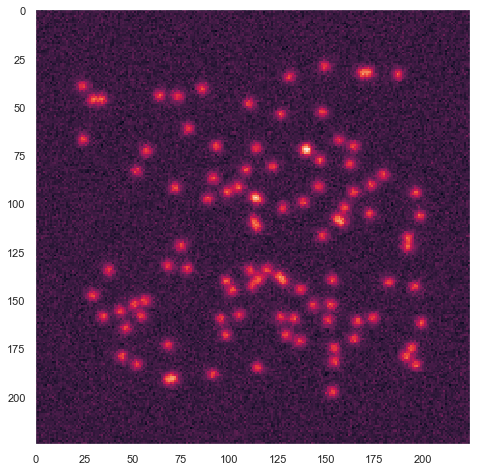

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axs.imshow(mbobs[0][0].image)
axs.grid(False)

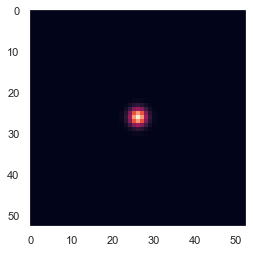

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
axs.imshow(mbobs[0][0].psf.image)
axs.grid(False)

## Run Metadetect

In [7]:
from metadetect.metadetect import Metadetect
from coadd_mdetsims.defaults import METADETECT_CONFIG

In [8]:
md = Metadetect(METADETECT_CONFIG, mbobs, np.random.RandomState(seed=42))
md.go()

In [9]:
res = md.result

In [10]:
from coadd_mdetsims.shear_bias_meas import measure_shear_metadetect

data = measure_shear_metadetect(res, s2n_cut=10, t_ratio_cut=1.2, cut_interp=False)

In [11]:
data

array([(0.02075651, 88., 0.00980781, 89., 0.01477057, 89., 0.00497952, 89., 0.00078669, 85., 0.00273712, 89.)],
      dtype=[('g1p', '<f4'), ('n1p', '<f4'), ('g1m', '<f4'), ('n1m', '<f4'), ('g1', '<f4'), ('n1', '<f4'), ('g2p', '<f4'), ('n2p', '<f4'), ('g2m', '<f4'), ('n2m', '<f4'), ('g2', '<f4'), ('n2', '<f4')])

In [12]:
R11 = (data['g1p'] - data['g1m']) / 2 / 0.01
y1 = data['g1'] / R11

R22 = (data['g2p'] - data['g2m']) / 2 / 0.01
y2 = data['g2'] / R22

print('g1|g2:', y1, y2)

g1|g2: [0.02698142] [0.01305618]


## Run A Set of Sims

In [13]:
import tqdm

data_p = []
data_m = []
for seed in tqdm.trange(100):
    sim = CoaddingSim(rng=seed, g1=0.02, g2=0.0)
    mbobs = sim.get_mbobs()
    md = Metadetect(METADETECT_CONFIG, mbobs, np.random.RandomState(seed=42))
    md.go()
    res = md.result
    data_p.append(measure_shear_metadetect(res, s2n_cut=10, t_ratio_cut=1.2, cut_interp=False))
    
    sim = CoaddingSim(rng=seed, g1=-0.02, g2=0.0)
    mbobs = sim.get_mbobs()
    md = Metadetect(METADETECT_CONFIG, mbobs, np.random.RandomState(seed=42))
    md.go()
    res = md.result
    data_m.append(measure_shear_metadetect(res, s2n_cut=10, t_ratio_cut=1.2, cut_interp=False))

100%|██████████| 100/100 [06:33<00:00,  3.93s/it]


In [14]:
data_p = np.concatenate(data_p)
data_m = np.concatenate(data_m)

In [16]:
from coadd_mdetsims.shear_bias_meas import estimate_m_and_c

estimate_m_and_c(data_p, data_m, 0.02, rng=None, n_boot=100)

100%|██████████| 100/100 [00:00<00:00, 2561.36it/s]


(0.006407204228621621,
 0.02460643340552556,
 0.0018745297089181553,
 0.0021800540531543566)